# Numerical Recipes Workshop 7
For the week of 4-8 November, 2019

This notebook will cover Monte Carlo error estimation.

In [1]:
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
from scipy.integrate import solve_ivp

In [2]:
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 14

## Estimating baseball travel distances

Previously, in workshop 4, you calculated the distance traveled by a baseball hit with a given launch angle and exit velocity. Now, let's assume that baseballs are hit with a distribution of launch angles and exit velocities. We will use this information to calculate the distribution of travel distances. Below are the relevant constants and functions for integrating baseball flight paths. Note, we have changed the criterion for balls landing to when they hit the ground as opposed to landing on the outfield wall.

In [5]:
## Constants
# baseballs
m = 0.145 # kg
c = 23.2 # cm
r = c / 2 / np.pi
A = np.pi * (r)**2 / 10000 # m^2
Cd = 0.346

# Earth-related constants
rhoE = 1.19657921 # kg/m^3
g = 9.80665 # m/s^2

In [6]:
def baseball_flight(t, f):
    """
    f0 = x  => dx/dt  = vx
    f1 = y  => dy/dt  = vy
    f2 = vx => dvx/dt = Fdx / m
    f3 = vy => dvy/dt = Fdy / m - g
    """

    vals = np.zeros(4)
    vals[0] = f[2]
    vals[1] = f[3]

    # drag force
    v2 = f[2]**2 + f[3]**2
    Fd = 0.5 * Cd * A * rhoE * v2

    xhat = f[2] / np.sqrt(v2)
    yhat = f[3] / np.sqrt(v2)
    vals[2] = -xhat * Fd / m
    vals[3] = -yhat * Fd / m - g

    return vals

def ball_lands(t, f):
    return f[1]
ball_lands.terminal = True
ball_lands.direction = -1

### Launch angle and exit velocity distributions

Below are reasonable approximations to angle and velocity distributions for hit baseballs.

* **launch angles**: assume a normal distribution with a mean of 17 degrees with a standard deviation of 5 degrees. (This is not actually reasonable, but go with it for now.)
* **exit velocities**: assume a normal distribution with a mean of 100 mph (\~45 m/s) with a standard deviation of 6 mph (\~2.7 m/s).

Use the Monte Carlo method to calculate the distance distribution. You will first need to construct random samples of angles and velocities, these use these to calculate to simulate baseball paths.

Below is a function that can be used to calculate the travel distance for a single exit velocity and launch angle.

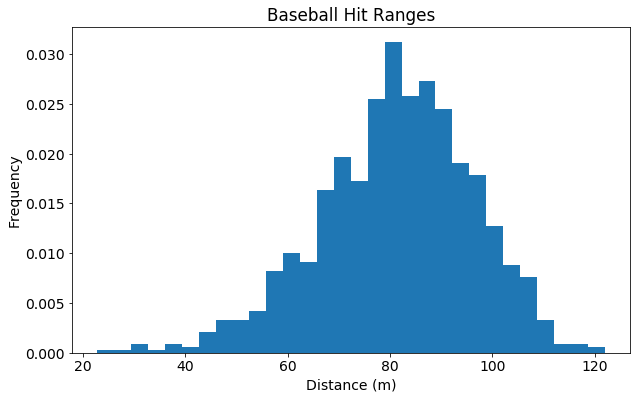

In [34]:
def baseball_travel_distance(velocity, angle):
    """
    Parameters
    ----------
    velocity: float
        Exit velocity in m/s.
    angle: float
        Launch angle in degrees.
        
    Returns
    -------
    distance: float
        Total x displacement after hitting the ground in meters.
        If ball does not hit the ground in 10 seconds, return NaN.
    """

    vxi = velocity * np.cos(angle * np.pi / 180)
    vyi = velocity * np.sin(angle * np.pi / 180)
    fi = np.array([0., 1., vxi, vyi])

    sol = solve_ivp(baseball_flight, (0, 10), fi, events=(ball_lands), dense_output=True)
    if sol.t_events[0].size < 1:
        return np.nan
    else:
        return sol.sol(sol.t_events[0])[0][0]
    
def get_distances():
    samples = 1000
    distances = []
    y = []
    for i in range(samples):
        ini_theta = np.random.normal(17, scale = 5)
        ini_v = np.random.normal(loc = 45, scale = 2.7)
        distances.append(baseball_travel_distance(ini_v, ini_theta))
        
    plt.title('Baseball Hit Ranges')
    plt.xlabel('Distance (m)')
    plt.ylabel('Frequency')
    plt.hist(distances, bins = 30, density = True)
    plt.plot()
get_distances() 

def my_gaussian(x, mu=0, sigma=1):
    y = 1/np.sqrt((2*np.pi*(sigma)**2))*np.exp(-(x-mu)**2/(2*(sigma)**2))
    return y


### Estimating distance distribution with the Monte-Carlo method

Now, use the random angle and velocity samples to perform a few thousand simulations. Plot histograms of the distributions of angle, velocity, and distance. Calculate the coefficients of variation (standard deviation divided by the mean) for each distribution. Overplot an appropriately configured Gaussian curve. How well does the distance distribution fit the curve?

angles cov is:  0.28016441394487884
velocities cov is:  0.060289779219089984
distances cov is:  0.18608627790290985


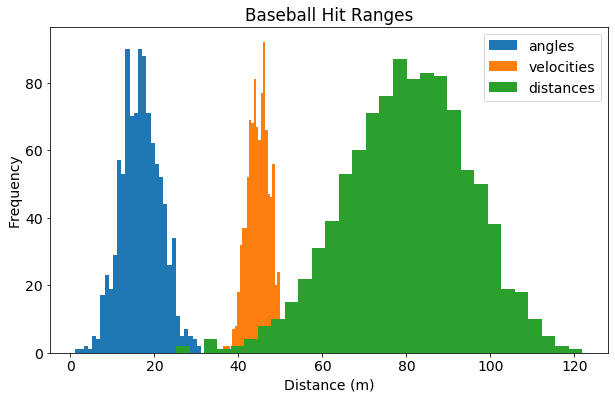

In [35]:
def monte_carlo():
    samples = 1000
    distances = np.zeros(samples)
    velocities = np.zeros(samples)
    angles = np.zeros(samples)
    for i in range(samples):
        angles[i] = np.random.normal(17, scale = 5)
        velocities[i] = np.random.normal(loc = 45, scale = 2.7)
        distances[i] = baseball_travel_distance(velocities[i], angles[i])
    cov_angles = np.std(angles) / np.mean(angles)
    cov_velocities = np.std(velocities) / np.mean(velocities)
    cov_distances = np.std(distances) / np.mean(distances)
    print("angles cov is: ", cov_angles)
    print("velocities cov is: ", cov_velocities)
    print("distances cov is: ", cov_distances)
    
    plt.title('Baseball Hit Ranges')
    plt.xlabel('Distance (m)')
    plt.ylabel('Frequency')
    plt.hist(angles, bins = 30, label = 'angles')
    
    plt.title('Baseball Hit Ranges')
    plt.xlabel('Distance (m)')
    plt.ylabel('Frequency')
    plt.hist(velocities, bins = 30, label = 'velocities')
    
    plt.title('Baseball Hit Ranges')
    plt.xlabel('Distance (m)')
    plt.ylabel('Frequency')
    plt.hist(distances, bins = 30, label = 'distances')
    plt.legend()
monte_carlo()
    
    

In reality, the standard deviation of the launch angle distribution is closer to about 21 degrees. Perform a new set of simulations with this angle distribution. How does this affect the distribution of distances?